# 03 - EDA - Exploratory Data Analysis

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data = pd.read_csv(os.path.join('..','data','processed','prepared_football_data.csv'))

data_for_back_testing = data[['implied_home_win_prob','implied_draw_prob','implied_away_win_prob']]

# removing the implied probabilities, this is only nedded for backtesting
data = data.drop(columns=['implied_home_win_prob','implied_draw_prob','implied_away_win_prob'])

print(data.shape)

data.head()

(7320, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Dtypes, Missing, Values, Duplicates, ...

In [5]:
data.dtypes.value_counts()

float64    88
int64       4
object      3
Name: count, dtype: int64

In [6]:
def check_data(data):
    data_check = pd.DataFrame()
    data_check['Data Types'] = data.dtypes
    data_check['Missing Values'] = data.isnull().sum()
    data_check['Unique Values'] = data.nunique()
    data_check['Duplicates'] = [data.duplicated().sum()] + [None] * (data.shape[1] - 1)

    # Calculate outliers using z-score approach
    def detect_outliers(column):
        if np.issubdtype(column.dtype, np.number):  # Only apply to numeric columns
            z_scores = (column - column.mean()) / column.std()
            return ((z_scores.abs() > 3).sum())
        return None  # Return None for non-numeric columns
    
    data_check['Outliers (Z>3)'] = data.apply(detect_outliers)
    
    # Add basic statistics for numeric columns
    data_check['Mean'] = data.select_dtypes(include=[np.number]).mean()
    data_check['Median'] = data.select_dtypes(include=[np.number]).median()
    data_check['Min'] = data.select_dtypes(include=[np.number]).min()
    data_check['Max'] = data.select_dtypes(include=[np.number]).max()
    
    # Shape of the dataset
    data_check.loc['Shape'] = [''] * len(data_check.columns)
    data_check.loc['Shape', 'Data Types'] = f"Rows: {data.shape[0]}, Columns: {data.shape[1]}"
    
    return data_check

check_data(data).head()

,Data Types,Missing Values,Unique Values,Duplicates,Outliers (Z>3),Mean,Median,Min,Max
home_team,object,0,44,16.0,NaN,NaN,NaN,NaN,NaN
away_team,object,0,44,NaN,NaN,NaN,NaN,NaN,NaN
full_time_result,object,0,3,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,int64,0,7,NaN,0.0,4.46776,5.0,0.0,6.0
month,int64,0,12,NaN,0.0,6.729508,8.0,1.0,12.0


## Correlations

In [8]:
# We'll use correlation matrix to identify highly correlated features

# Select only numerical features
numerical_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numerical_data.corr()

threshold = 0.8

# Get the correlation matrix and filter for correlations above the threshold
high_corr_pairs = corr_matrix.where((corr_matrix.abs() > threshold) & (corr_matrix != 1))

# Drop NA values for a cleaner view
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_corr_pairs.head(15)

print(f"we have {high_corr_pairs.shape[0]} pairs of highly correlated features")

we have 262 pairs of highly correlated features


## VIF - Variance Inflation Factor

In [9]:
# We'll use the variance inflation factor (VIF) to check for multicollinearity and remove features with high VIF values.

# Add constant column for VIF calculation
X = add_constant(numerical_data)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort features by VIF
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

print(vif_data)

/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 Feature         VIF
8       away_roll_3_avg_home_total_goals         inf
9       home_roll_3_avg_away_total_goals         inf
10      away_roll_3_avg_away_total_goals         inf
7       home_roll_3_avg_home_total_goals         inf
49      home_roll_5_avg_home_total_goals         inf
90       away_roll_5_avg_goal_difference         inf
89       home_roll_5_avg_goal_difference         inf
48       away_roll_3_avg_goal_difference         inf
47       home_roll_3_avg_goal_difference         inf
51      home_roll_5_avg_away_total_goals         inf
52      away_roll_5_avg_away_total_goals         inf
50      away_roll_5_avg_home_total_goals         inf
63            home_roll_5_avg_away_fouls  116.242454
61            home_roll_5_avg_home_fouls  112.104099
53      home_roll_5_avg_home_total_shots  111.508875
57  home_roll_5_avg_home_shots_on_target  109.951245
64            away_roll_5_avg_away_fouls  109.221289
54      away_roll_5_avg_home_total_shots  105.

- Features with inf VIFs should be removed as they are collinear with other features, and keeping them will lead to multicollinearity problems. These features are redundant and contribute nothing to the model because they are fully predictable by the other features.
- Features with high VIFs (e.g., VIF > 10 or 20) should be reviewed and potentially removed. A common approach is to drop features with VIFs above 10, though this can vary depending on the specific domain and modeling context

In [10]:
#Copy data to avoid modifying original data
data = data.copy()

# Define the threshold for VIF
threshold_vif = 20

# Get the list of features with inf VIFs or VIF greater than the threshold
high_vif_features = vif_data[(vif_data['VIF'] == float('inf')) | (vif_data['VIF'] > threshold_vif)]['Feature'].tolist()

# Remove 'const' if it's in the list of features to drop
high_vif_features = [feature for feature in high_vif_features if feature != 'const']

# Drop the identified high VIF features
data.drop(columns=high_vif_features, inplace=True)

In [11]:
len(high_vif_features)

48

In [12]:
# checking remaining features
vif_data[~((vif_data['VIF'] == float('inf')) | (vif_data['VIF'] > threshold_vif))]

,Feature,VIF
46,away_roll_3_avg_ratio_a_h_fouls,19.444258
45,home_roll_3_avg_ratio_a_h_fouls,19.054803
66,away_roll_5_avg_home_corners,19.044720
65,home_roll_5_avg_home_corners,18.286291
67,home_roll_5_avg_away_corners,15.405484
68,away_roll_5_avg_away_corners,15.177746
41,home_roll_3_avg_ratio_h_a_fouls,13.644870
42,away_roll_3_avg_ratio_h_a_fouls,12.835318
81,home_roll_5_avg_ratio_h_a_shots,12.654955
86,away_roll_5_avg_ratio_a_h_shots,11.999871


##  Cluster maps

<Figure size 2000x1000 with 0 Axes>

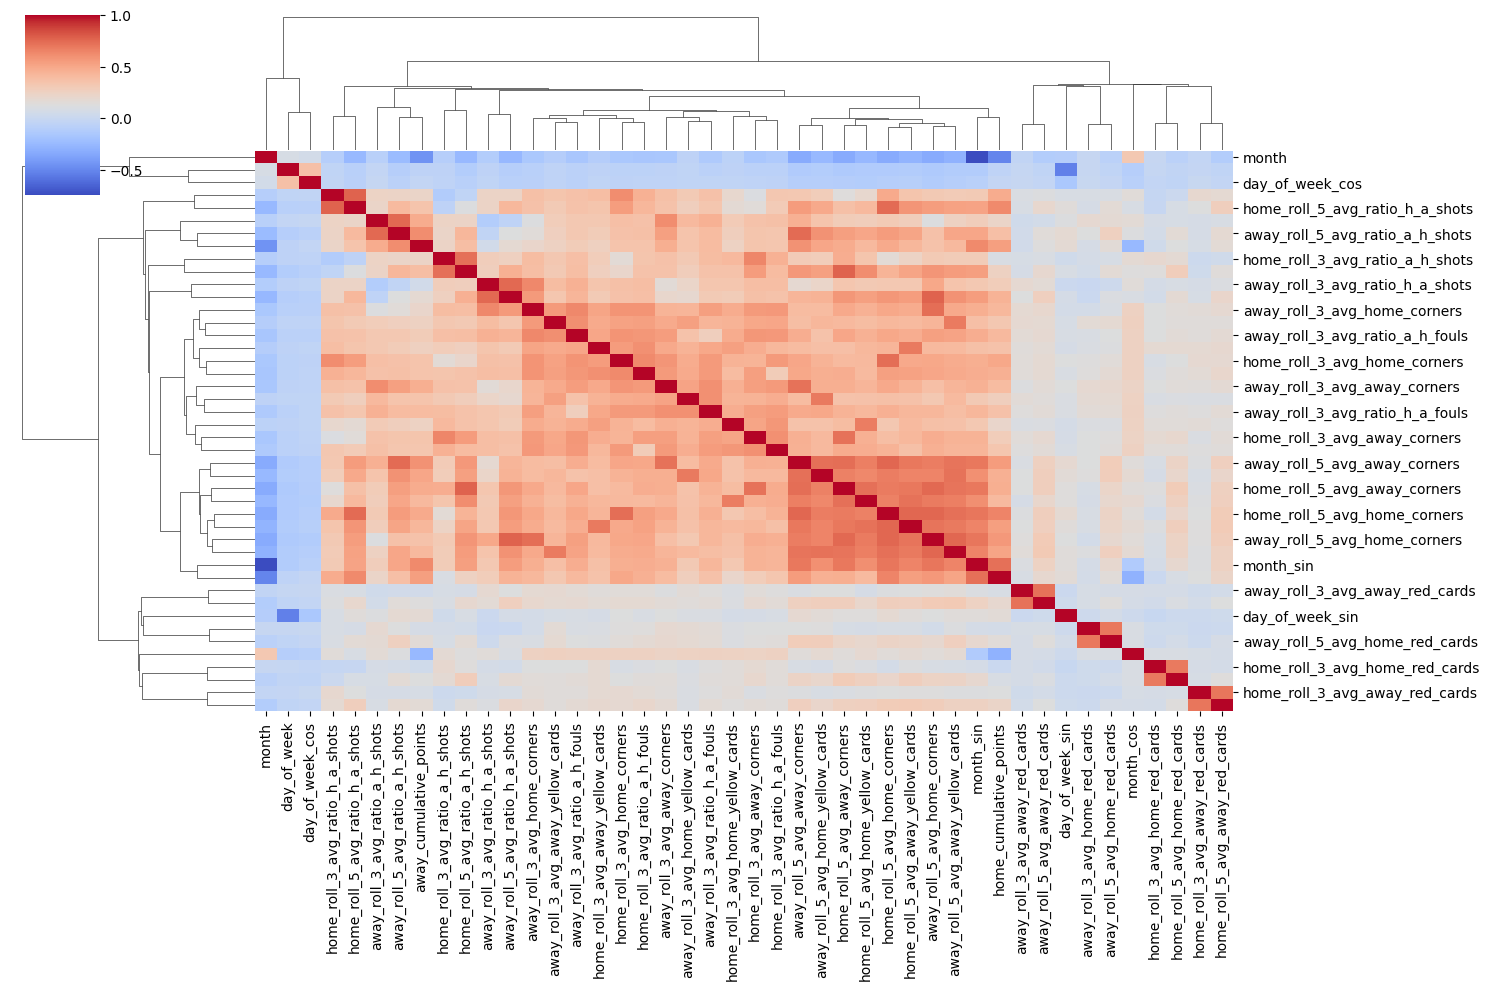

In [13]:
# Plot a clustered heatmap with only the data features resulting from VIF analysis
numerical_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numerical_data.corr()

plt.figure(figsize=(20, 10))
sns.clustermap(corr_matrix, cmap='coolwarm', annot=False, figsize=(15, 10))
plt.show();

There are still hight correlated feature but we'll use them for now and filter feature with RFECV (Recursive featrue elimination with cross validation) during model selection

## Target Distribution

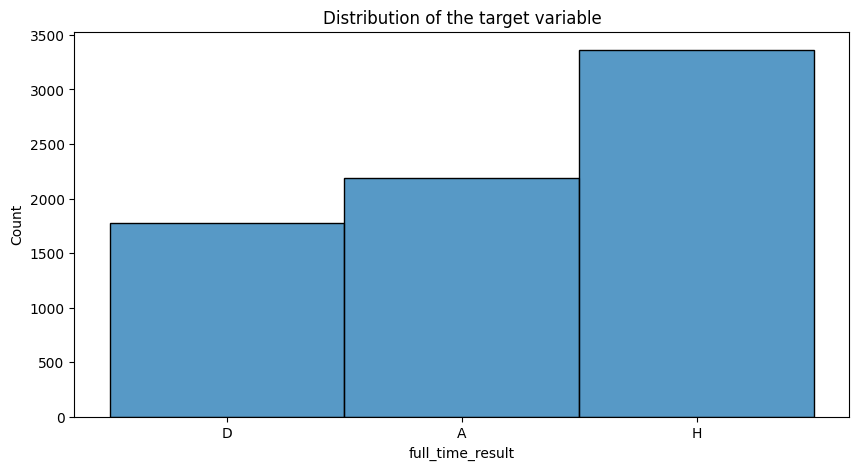

In [14]:
# show the distribution of the target variable
plt.figure(figsize=(10,5))
sns.histplot(data['full_time_result'])
plt.title('Distribution of the target variable')
plt.show()

In [15]:
print(data.shape)

data.head()

(7320, 47)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,man city,west brom,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,middlesbrough,liverpool,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [16]:
# save the data
data.to_csv(os.path.join('..','data','processed','data_for_model.csv'), index=False)
data_for_back_testing.to_csv(os.path.join('..','data','processed','data_for_back_testing.csv'), index=False)